# Data simulation code by Le Borgne and Bontempi (2021)

This section does not need to be run. All the simulated data is saved in /simulations_new/.

In [84]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [ ]:
def generate_customer_profiles_table(n_customers, random_state=0):
    np.random.seed(random_state)
    customer_id_properties=[]
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

def generate_terminal_profiles_table(n_terminals, random_state=0):
    np.random.seed(random_state)
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    return terminal_profiles_table

def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    # Use numpy arrays in the following to speed up computations
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(customer_profile.CUSTOMER_ID)
    np.random.seed(customer_profile.CUSTOMER_ID)
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions

In [ ]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", seed=0, r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = seed)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = seed+1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel (we only have one CPU)
    # customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [ ]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=1, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & # Note you halved this value
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=2, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+7) & # Note you halved this value
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 

In [ ]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 15000, 
                     nb_days=60, 
                     start_date="2018-04-01", 
                     r=5)

Time to generate customer profiles table: 0.069s
Time to generate terminal profiles table: 0.096s
Time to associate terminals to customers: 3.4s
Time to generate transactions: 6.7e+01s


In [ ]:
#19071 when n_customers = 5000
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0
1,1,2018-04-01 00:02:10,4961,8673,81.51,130,0
2,2,2018-04-01 00:07:56,2,14653,146.00,476,0
3,3,2018-04-01 00:09:29,4128,10310,64.49,569,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0
...,...,...,...,...,...,...,...
575750,575750,2018-05-30 23:57:05,2535,2083,26.77,5183825,59
575751,575751,2018-05-30 23:57:07,4434,6939,81.88,5183827,59
575752,575752,2018-05-30 23:59:20,2351,10612,27.67,5183960,59
575753,575753,2018-05-30 23:59:24,1044,3736,32.11,5183964,59


Fraud 1 484
Fraud 2 789
Fraud 3 698

In [ ]:
mean_fraud = []
for i in range(100):
  (customer_profiles_table, terminal_profiles_table, transactions_df)=\
      generate_dataset(n_customers = 5000, 
                      n_terminals = 15000, 
                      nb_days=45, 
                      start_date="2018-04-01",
                      seed = i,
                      r=5)

  %time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

  fraud_rate = transactions_df[transactions_df["TX_TIME_DAYS"] >= 43].TX_FRAUD.mean()
  print(fraud_rate)
  mean_fraud.append(fraud_rate)

  %time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)
  %time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

  %time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
  transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

  %time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
  transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

  DIR_OUTPUT = f"/content/drive/MyDrive/data/simulations_new/simul_{i+1}/"

  if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

  start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

  for day in range(transactions_df.TX_TIME_DAYS.max()-1, transactions_df.TX_TIME_DAYS.max()+1):
      
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

print(np.sum(fraud_rate) / 100)

Time to generate customer profiles table: 0.066s
Time to generate terminal profiles table: 0.1s
Time to associate terminals to customers: 3.5s
Time to generate transactions: 5.7e+01s
Number of frauds from scenario 1: 239
Number of frauds from scenario 2: 351
Number of frauds from scenario 3: 342
CPU times: user 7.67 s, sys: 44.4 ms, total: 7.72 s
Wall time: 7.72 s
0.0017788939465285408
CPU times: user 2.31 s, sys: 7.9 ms, total: 2.31 s
Wall time: 2.32 s
CPU times: user 2.31 s, sys: 11.6 ms, total: 2.32 s
Wall time: 2.32 s
CPU times: user 53.3 s, sys: 541 ms, total: 53.8 s
Wall time: 53.3 s
CPU times: user 3min 35s, sys: 4.47 s, total: 3min 39s
Wall time: 3min 35s
Time to generate customer profiles table: 0.069s
Time to generate terminal profiles table: 0.11s
Time to associate terminals to customers: 3.3s
Time to generate transactions: 5.7e+01s
Number of frauds from scenario 1: 248
Number of frauds from scenario 2: 350
Number of frauds from scenario 3: 364
CPU times: user 7.83 s, sys: 4

In [ ]:
print(np.sum(mean_fraud) / 100)
print(np.std(mean_fraud))

0.0021823714554308825
0.00032668815156989476


In [ ]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 310
Number of frauds from scenario 2: 493
Number of frauds from scenario 3: 468
CPU times: user 12.9 s, sys: 93 ms, total: 13 s
Wall time: 13 s


In [ ]:
transactions_df.TX_FRAUD.mean()
#transactions_df.head()

0.0022075361916092783

In [ ]:
DIR_OUTPUT = "/content/drive/MyDrive/data/simulations"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

# Feature transformation by Le Borgne and Bontempi (2021)

This section does not need to be run. All the simulated data is saved in /simulation_new/simul_file_number_thresh.csv, and in the folder /mc_pltr_thresh/

In [ ]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [ ]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

# Calculating threshold effects

This code calculates the univariate and bivariate threshold effects for the real-world credit card data.

Note: this section does not need to be run unless you would like to recreate the experiment by re-generating the threshold effects again.

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
# NOTE: CHANGE FILE DIRECTORY TO LOCATION OF CREDITCARD.CSV
data = pd.read_csv("/content/drive/MyDrive/data/creditcard.csv")
data.head(10)

In [ ]:
Y = data.values[:, -1].astype(int)
X = data.values[:, 1:-1]
data_labels = data.columns[1:-1]
print(data_labels)
print(X.shape)

In [ ]:
# Skip this cell if you don't want a visualization
clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3)
clf.fit(X[:,(1,2)], Y)
tree.plot_tree(clf)
plt.show()

In [ ]:
# feature[0] gives the feature of the root
# threshold[0] gives the feature of the root
# If feature[1] is -2, then the expanding branch
# is on the right hand side. So the decision rule sign is <=
# If feature[1] is not -2, then the expanding branch
# is on the left hand side. so the decision rule sign is >=
#
# The feature for the second branch is stored in either feature[1] or feature[2]
# whichever is not non-negative. Only grab the value. The sign is always <=.
# 
# Create two dictionaries, uni-thresh and bi-thresh.
# For uni-thresh, store the feature #, the sign, and the threshold
# For bi-thresh, store the feature # and the threshold

n = X.shape[1]
uniThresh = {}
biThresh = {}
for i in range(n-1):
  for j in range(i+1, n):
    print(f"i: {i}, j: {j}")
    clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3)
    clf.fit(X[:,(i,j)], Y)
    
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    right_weighted = (feature[1] < 0)
    k = (i if feature[0] == 0 else j)
    sign = ("<=" if right_weighted else ">")
    d_k = threshold[0]
    if k not in uniThresh:
      print(f"univariate found: {k}")
      uniThresh[k] = (sign, d_k)

    l_index = (2 if right_weighted else 1)
    l = (i if feature[l_index] == 0 else j)
    if (l != k) and ((k,l) not in biThresh):
      print(f"bivariate found: {k}, {l}")
      biThresh[(k, l)] = threshold[l_index]

print(uniThresh, biThresh)

In [ ]:
# Metrics of threshold effects
print(len(uniThresh))
print(len(biThresh))
print(len(biThresh) + len(uniThresh))
print(f"max bivariate: {int(n * (n-1) / 2)}")
print(f"rate of bivariate effects: {len(biThresh)/int(n * (n-1) / 2)}")
print(n + int(n * (n-1)/2))

In [ ]:
# Adds univariate effects to real-world credit data
for i in uniThresh:
  label = data_labels[i]
  sign = uniThresh[i][0]
  d = uniThresh[i][1]
  threshold_var = label + sign + "{:.2f}".format(d)
  if sign == "<=":
    data[threshold_var] = (data[label] <= d).astype(int)
  else:
    data[threshold_var] = (data[label] > d).astype(int)

In [ ]:
# Adds bivaraite effects to real-world credit data
for i, j in biThresh:
  primary_label = data_labels[i]
  second_label = data_labels[j]
  sign = uniThresh[i][0]
  d_i = uniThresh[i][1]
  d_j = biThresh[(i,j)]
  if sign == "<=":
    actual_sign = ">"
  else:
    actual_sign = "<="
  threshold_var = primary_label + actual_sign + "{:.2f}".format(d_i) +\
  "," + second_label + "<=" + "{:.2f}".format(d_j)
  if sign == "<=":
    data[threshold_var] = ((data[primary_label] > d_i) & (data[second_label] <= d_j)).astype(int)
  else:
    data[threshold_var] = ((data[primary_label] <= d_i) & (data[second_label] <= d_j)).astype(int)
data

In [ ]:
# Saves credit card data with threshold effects
data.to_csv("/content/drive/MyDrive/data/creditcard_thresh.csv")

# PLTR Coefficient Analysis

The code in this section analyzes the coefficients returned by PLTR. Again, it does not need to be run, unless you wish to view the results yourself.

NOTE: There are many file directory locations. You will need to adjust all file paths as appropriate.

In [145]:
import pandas as pd

In [142]:
# Analyzes Monte Carlo simulation PLTR coefficients. Randomly selects 3 
# samples, determined by random number generator to be 4, 10, 22
#
# NOTE: Due to numerical instability in the R code, the samples 1, 50, and 81
# are invalid. DO NOT SAMPLE THOSE.
#
# Returns a dictionary of coefficients and prints the top 5 greatest
# coefficients (absolute value) in a LaTeX inputable matrix.
for l in [4, 10, 22]:
  # NOTE: CHANGE THIS FILE DIRECTORY TO THE /mc_pltr_thresh/ LOCATION
  data = pd.read_csv(f"/content/drive/MyDrive/data/mc_pltr_thresh/simul_{l}_thresh.csv", index_col=0)
  features = data.drop(["TX_FRAUD"], axis=1)

  thresh_effect_mean = []
  coef_values = {}
  feature_selected = {}
  for a in [1, 2]:
    for b in range(1, 6):
      # NOTE: CHANGE THIS FILE DIRECTORY TO THE /pltr_coeffs/ LOCATION
      # TWO Fs IN FOLDER NAME. ONE F IS REAL-WORLD, NOT SIMULATED
      pltr_coef = pd.read_csv(f"/content/drive/MyDrive/data/pltr_coeffs/{l}alasso_coef{a}_{b}.txt",
                              sep=' ',
                              skiprows=2,
                              names=["feature_idx", "bool", "coef_value"])
      count = 0
      for row in pltr_coef.to_numpy():
        i, j, k = row
        if i == 1:
          continue
        if (i-2) >= 15:
          count += 1
        if features.columns[int(i-2)] in coef_values:
          coef_values[features.columns[int(i-2)]] += k
        else:
          coef_values[features.columns[int(i-2)]] = k
        if features.columns[int(i-2)] in feature_selected:
          feature_selected[features.columns[int(i-2)]] += 1
        else:
          feature_selected[features.columns[int(i-2)]] = 1
      thresh_effect_mean.append(count)
  print(sum(thresh_effect_mean) / 10)
  print(coef_values)
  mean_coef_values = {k: v / 10 for k, v in coef_values.items()}
  mean_coef_values_sorted = sorted(mean_coef_values, 
        key=lambda dict_key: abs(mean_coef_values[dict_key]), reverse=True)
  for idx, feature in enumerate(mean_coef_values_sorted):
    if idx == 5: break
    print(feature_selected[feature], "&", feature, "&", mean_coef_values[feature], "\\\\")

10.7
{'TX_AMOUNT': 6.340186769884397, 'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 0.07844906268719835, 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': -0.18724567825498364, 'CUSTOMER_ID_NB_TX_7DAY_WINDOW': -0.07743162508150808, 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': -0.6189457974319643, 'CUSTOMER_ID_NB_TX_30DAY_WINDOW': -0.12393547736784652, 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': -1.09330583460844, 'TERMINAL_ID_NB_TX_1DAY_WINDOW': -0.00962540817637074, 'TERMINAL_ID_RISK_1DAY_WINDOW': 0.1310850314539721, 'TERMINAL_ID_NB_TX_7DAY_WINDOW': 0.24502153065165042, 'TERMINAL_ID_RISK_7DAY_WINDOW': -0.16281033392876343, 'TERMINAL_ID_NB_TX_30DAY_WINDOW': 0.3707932563583061, 'TERMINAL_ID_RISK_30DAY_WINDOW': -0.2859398393398318, 'TX_AMOUNT>218.64': 13.938620358955166, 'CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50': -0.12466265522549502, 'CUSTOMER_ID_NB_TX_30DAY_WINDOW>103.50': -0.27402825749852106, 'TERMINAL_ID_NB_TX_30DAY_WINDOW<=25.50': -0.9052844075463918, 'CUSTOMER_ID_NB_TX_7DAY_WINDOW>27.50': -0.44231645314274215, 'TERMINAL_

This is the same code, but parameters modified to read the real-world credit card data. Run all cells if you wish to analyze the PLTR coefficients of the real world data, however, again, all the values are stored.

In [134]:
data = pd.read_csv("/content/drive/MyDrive/data/creditcard_thresh.csv", index_col=0)
data

,TX_AMOUNT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_DURING_WEEKEND,TX_DURING_NIGHT,TX_FRAUD,TX_AMOUNT>218.64,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW>192.52,CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW<=115.67,CUSTOMER_ID_NB_TX_30DAY_WINDOW>103.50,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW<=105.53,TERMINAL_ID_RISK_1DAY_WINDOW<=0.75,TERMINAL_ID_RISK_7DAY_WINDOW<=0.54,TERMINAL_ID_NB_TX_30DAY_WINDOW<=25.50,TERMINAL_ID_RISK_30DAY_WINDOW<=0.16,CUSTOMER_ID_NB_TX_7DAY_WINDOW>27.50,TERMINAL_ID_NB_TX_1DAY_WINDOW<=3.50,TERMINAL_ID_NB_TX_7DAY_WINDOW<=6.50,TX_DURING_NIGHT<=0.50,"TX_AMOUNT<=218.64,TERMINAL_ID_RISK_1DAY_WINDOW<=0.75","TX_AMOUNT<=218.64,TERMINAL_ID_RISK_7DAY_WINDOW<=0.54","TX_AMOUNT<=218.64,TERMINAL_ID_RISK_30DAY_WINDOW<=0.16","CUSTOMER_ID_NB_TX_1DAY_WINDOW>3.50,CUSTOMER_ID_NB_TX_7DAY_WINDOW<=27.50","CUSTOMER_ID_NB_TX_1DAY_WINDOW>3.50,TERMINAL_ID_NB_TX_1DAY_WINDOW<=3.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50","CUSTOMER_ID_NB_TX_1DAY_WINDOW>3.50,TERMINAL_ID_NB_TX_7DAY_WINDOW<=6.50","TERMINAL_ID_NB_TX_30DAY_WINDOW>25.50,CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,CUSTOMER_ID_NB_TX_7DAY_WINDOW<=9.50","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW<=118.55","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,CUSTOMER_ID_NB_TX_30DAY_WINDOW<=47.00","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW<=106.17","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,TERMINAL_ID_NB_TX_7DAY_WINDOW<=5.50","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,TERMINAL_ID_RISK_7DAY_WINDOW<=0.54","CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW<=192.52,TX_DURING_NIGHT<=0.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,CUSTOMER_ID_NB_TX_7DAY_WINDOW<=5.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW<=115.67","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,CUSTOMER_ID_NB_TX_30DAY_WINDOW<=24.00","TERMINAL_ID_NB_TX_30DAY_WINDOW>25.50,CUSTOMER_ID_NB_TX_30DAY_WINDOW<=94.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW<=24.23","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,TERMINAL_ID_NB_TX_1DAY_WINDOW<=3.50","TERMINAL_ID_NB_TX_1DAY_WINDOW>3.50,TERMINAL_ID_NB_TX_7DAY_WINDOW<=9.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,TERMINAL_ID_NB_TX_7DAY_WINDOW<=6.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,TERMINAL_ID_NB_TX_30DAY_WINDOW<=21.50","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,TERMINAL_ID_RISK_30DAY_WINDOW<=0.13","TERMINAL_ID_RISK_1DAY_WINDOW>0.75,TX_DURING_NIGHT<=0.50","TERMINAL_ID_NB_TX_7DAY_WINDOW>6.50,TX_DURING_NIGHT<=0.50","TERMINAL_ID_RISK_7DAY_WINDOW>0.54,TERMINAL_ID_NB_TX_30DAY_WINDOW<=21.50","TERMINAL_ID_RISK_7DAY_WINDOW>0.54,TERMINAL_ID_RISK_30DAY_WINDOW<=0.25"
0,50.01,2.0,41.640000,6.0,67.813333,22.0,79.776364,2.0,0.0,3.0,0.0,14.0,0.0,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33.54,7.0,34.248571,28.0,30.012143,87.0,30.585402,1.0,0.0,3.0,0.0,24.0,0.0,0,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114.53,5.0,76.780000,26.0,60.030385,103.0,55.663301,0.0,0.0,2.0,0.0,10.0,0.0,0,1,0,0,0,0,1,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.81,3.0,9.926667,16.0,13.826250,76.0,16.816316,3.0,0.0,5.0,0.0,29.0,0.0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,90.47,3.0,101.406667,17.0,105.224118,82.0,102.030610,0.0,0.0,6.0,0.0,25.0,0.0,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [135]:
features = data.drop(["Time", "Class"], axis=1)
features.columns

Index(['TX_AMOUNT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'TX_AMOUNT>218.64', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW>192.52',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW<=115.67',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW>103.50',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW<=105.53',
       'TERMINAL_ID_RISK_1DAY_WINDOW<=0.75',
       'TERMINAL_ID_RISK_7DAY_WINDOW<=0.54',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW<=25.50',
       'TERMINAL_ID_RISK_30DAY_WINDOW<=0.16',
       'CUSTOMER_ID_NB_TX_7DA

In [139]:
# Analyzes real-world data PLTR coefficients. 
#
# Returns a dictionary of coefficients and prints the top 10 greatest
# coefficients (absolute value) in a LaTeX inputable matrix.
thresh_effect_mean = []
coef_values = {}
feature_selected = {}
for a in [1, 2]:
  for b in range(1, 6):
    # NOTE: CHANGE THIS FILE DIRECTORY TO THE /pltr_coefs/ LOCATION
    # ONLY ONE F IN FOLDER NAME. TWO Fs IS SIMULATED DATA, NOT REAL WORLD
    pltr_coef = pd.read_csv(f"/content/drive/MyDrive/data/pltr_coefs/alasso_coef{a}_{b}.txt",
                            sep=' ',
                            skiprows=2,
                            names=["feature_idx", "bool", "coef_value"])
    count = 0
    for row in pltr_coef.to_numpy():
      i, j, k = row
      if i == 1:
        continue
      if (i-2) >= 29:
        count += 1
      if features.columns[int(i-2)] in coef_values:
        coef_values[features.columns[int(i-2)]] += k
      else:
        coef_values[features.columns[int(i-2)]] = k
      if features.columns[int(i-2)] in feature_selected:
        feature_selected[features.columns[int(i-2)]] += 1
      else:
        feature_selected[features.columns[int(i-2)]] = 1
    thresh_effect_mean.append(count)
print(sum(thresh_effect_mean) / 10)
print(coef_values)
mean_coef_values = {k: v / 10 for k, v in coef_values.items()}
mean_coef_values_sorted = sorted(mean_coef_values, 
       key=lambda dict_key: abs(mean_coef_values[dict_key]), reverse=True)
for idx, feature in enumerate(mean_coef_values_sorted):
  if idx == 5: break
  print(feature_selected[feature], "&", feature, "&", mean_coef_values[feature], "//")

10.7
{'TX_AMOUNT': 6.340186769884397, 'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 0.07844906268719835, 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': -0.18724567825498364, 'CUSTOMER_ID_NB_TX_7DAY_WINDOW': -0.07743162508150808, 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': -0.6189457974319643, 'CUSTOMER_ID_NB_TX_30DAY_WINDOW': -0.12393547736784652, 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': -1.09330583460844, 'TERMINAL_ID_NB_TX_1DAY_WINDOW': -0.00962540817637074, 'TERMINAL_ID_RISK_1DAY_WINDOW': 0.1310850314539721, 'TERMINAL_ID_NB_TX_7DAY_WINDOW': 0.24502153065165042, 'TERMINAL_ID_RISK_7DAY_WINDOW': -0.16281033392876343, 'TERMINAL_ID_NB_TX_30DAY_WINDOW': 0.3707932563583061, 'TERMINAL_ID_RISK_30DAY_WINDOW': -0.2859398393398318, 'TX_AMOUNT>218.64': 13.938620358955166, 'CUSTOMER_ID_NB_TX_1DAY_WINDOW<=3.50': -0.12466265522549502, 'CUSTOMER_ID_NB_TX_30DAY_WINDOW>103.50': -0.27402825749852106, 'TERMINAL_ID_NB_TX_30DAY_WINDOW<=25.50': -0.9052844075463918, 'CUSTOMER_ID_NB_TX_7DAY_WINDOW>27.50': -0.44231645314274215, 'TERMINAL_

# Monte Carlo PLTR data preparation

In [85]:
# Reads simulated data using method from LeBorgne and Bontempi (2021)
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [119]:
input_features=['TX_AMOUNT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT']

necessary_features=['TX_AMOUNT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'TX_FRAUD']

In [ ]:
# This code calculates the threshold effects for the simulated data
# and then saves it
# 
# Has the same behavior as the "Calculating threshold effects" section
for idx in range(100):
  # NOTE: CHANGE THIS FILE PATH TO THE /simulations_new/ LOCATION
  DIR_INPUT=f"/content/drive/MyDrive/data/simulations_new/simul_{idx+1}/"

  BEGIN_DATE = "2018-05-14"
  END_DATE = "2018-05-15"

  print("Load  files")
  %time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
  print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))
  
  data = transactions_df[necessary_features]

  X = transactions_df[input_features].to_numpy()
  Y = transactions_df["TX_FRAUD"].to_numpy()

  n = X.shape[1]
  uniThresh = {}
  biThresh = {}
  for i in range(n-1):
    for j in range(i+1, n):
      #print(f"i: {i}, j: {j}")
      clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3)
      clf.fit(X[:,(i,j)], Y)
      
      feature = clf.tree_.feature
      threshold = clf.tree_.threshold
      right_weighted = (feature[1] < 0)
      k = (i if feature[0] == 0 else j)
      sign = ("<=" if right_weighted else ">")
      d_k = threshold[0]
      if k not in uniThresh:
        #print(f"univariate found: {k}")
        uniThresh[k] = (sign, d_k)

      l_index = (2 if right_weighted else 1)
      l = (i if feature[l_index] == 0 else j)
      if (l != k) and ((k,l) not in biThresh):
        #print(f"bivariate found: {k}, {l}")
        biThresh[(k, l)] = threshold[l_index]
  
  for i in uniThresh:
    label = input_features[i]
    sign = uniThresh[i][0]
    d = uniThresh[i][1]
    threshold_var = label + sign + "{:.2f}".format(d)
    if sign == "<=":
      data[threshold_var] = (data[label] <= d).astype(int)
    else:
      data[threshold_var] = (data[label] > d).astype(int)
  
  for i, j in biThresh:
    primary_label = input_features[i]
    second_label = input_features[j]
    sign = uniThresh[i][0]
    d_i = uniThresh[i][1]
    d_j = biThresh[(i,j)]
    if sign == "<=":
      actual_sign = ">"
    else:
      actual_sign = "<="
    threshold_var = primary_label + actual_sign + "{:.2f}".format(d_i) +\
    "," + second_label + "<=" + "{:.2f}".format(d_j)
    if sign == "<=":
      data[threshold_var] = ((data[primary_label] > d_i) & (data[second_label] <= d_j)).astype(int)
    else:
      data[threshold_var] = ((data[primary_label] <= d_i) & (data[second_label] <= d_j)).astype(int)
  
  data.to_csv("/content/drive/MyDrive/data/mc_pltr_thresh/" + f"simul_{idx+1}_thresh.csv")

# Random forest verification

This code has nothing to do with any of the results presented or necessary for the paper and should not be run. It serves as a way to verify Mason's results.

In [34]:
import csv
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

iterations = 1
APs = np.zeros((iterations*2, 2))

result = pd.read_csv("/content/drive/MyDrive/data/creditcard.csv")
Y = result.values[:, -1].astype(int)
Time = result.values[:, 0].astype(int)
X = result.values[:, 1:-1]

for i in tqdm(range(iterations)):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)
    clf3 = RandomForestClassifier(n_estimators=100, max_depth=10, verbose=True)
    clf3.fit(X_train, y_train)
#    disp = plot_precision_recall_curve(clf, X_test, y_test)
#    plt.show()
    APs[2*i, 0] = average_precision_score(y_train, clf3.predict(X_train))
    APs[2*i, 1] = average_precision_score(y_test, clf3.predict(X_test))

    clf4 = RandomForestClassifier(n_estimators=100, max_depth=10, verbose=True)
    clf4.fit(X_test, y_test)
    APs[2*i+1, 0] = average_precision_score(y_test, clf4.predict(X_test))
    APs[2*i+1, 1] = average_precision_score(y_train, clf4.predict(X_train))

    print(APs)


print(APs)
print(np.mean(APs, axis=0))
print(np.std(APs, axis=0))

'''
fig, ((ax0), (ax1)) = plt.subplots(nrows=1, ncols=2)
ax0.title.set_text('AP of Random Forest on training data')
ax1.title.set_text('AP of Random Forest on testing data')
ax0.hist(APs[:,0], alpha=.8, edgecolor='blue')
ax1.hist(APs[:,1], alpha=.8, edgecolor='red')
plt.show()
'''


0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[0.82529494 0.7486904 ]
 [0.85739566 0.6863649 ]]

[[0.82529494 0.7486904 ]
 [0.85739566 0.6863649 ]]
[0.8413453  0.71752765]
[0.01605036 0.03116275]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


"\nfig, ((ax0), (ax1)) = plt.subplots(nrows=1, ncols=2)\nax0.title.set_text('AP of Random Forest on training data')\nax1.title.set_text('AP of Random Forest on testing data')\nax0.hist(APs[:,0], alpha=.8, edgecolor='blue')\nax1.hist(APs[:,1], alpha=.8, edgecolor='red')\nplt.show()\n"

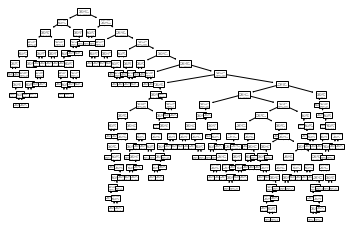

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1694827194, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=2109940951, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_fe

In [35]:
tree.plot_tree(clf4.base_estimator_.fit(X_train, y_train))
plt.show()
clf4.estimators_

In [26]:
print(f"depth: {clf2.base_estimator_.tree_.max_depth}")
print(f"nodes: {clf2.base_estimator_.tree_.node_count}")
print(f"predicates: {clf2.base_estimator_.tree_.n_features}")
print(f"terminal nodes: {clf2.base_estimator_.tree_.n_leaves}")
print()

depth: 19
nodes: 199
predicates: 29
terminal nodes: 100



In [39]:
mean_leaves = []
for estimator in clf4.estimators_:
  print(f"depth: {estimator.tree_.max_depth}")
  print(f"nodes: {estimator.tree_.node_count}")
  print(f"predicates: {estimator.tree_.n_features}")
  print(f"terminal nodes: {estimator.tree_.n_leaves}")
  mean_leaves.append(estimator.tree_.n_leaves)
  print(len(set(estimator.tree_.feature)))
  print()
print(np.sum(mean_leaves) / len(clf4.estimators_))

depth: 10
nodes: 125
predicates: 29
terminal nodes: 63
27

depth: 10
nodes: 97
predicates: 29
terminal nodes: 49
22

depth: 10
nodes: 81
predicates: 29
terminal nodes: 41
24

depth: 10
nodes: 99
predicates: 29
terminal nodes: 50
23

depth: 10
nodes: 95
predicates: 29
terminal nodes: 48
25

depth: 10
nodes: 85
predicates: 29
terminal nodes: 43
24

depth: 10
nodes: 93
predicates: 29
terminal nodes: 47
23

depth: 10
nodes: 101
predicates: 29
terminal nodes: 51
24

depth: 10
nodes: 123
predicates: 29
terminal nodes: 62
23

depth: 10
nodes: 111
predicates: 29
terminal nodes: 56
27

depth: 10
nodes: 97
predicates: 29
terminal nodes: 49
24

depth: 10
nodes: 93
predicates: 29
terminal nodes: 47
23

depth: 10
nodes: 81
predicates: 29
terminal nodes: 41
20

depth: 10
nodes: 89
predicates: 29
terminal nodes: 45
26

depth: 10
nodes: 129
predicates: 29
terminal nodes: 65
27

depth: 10
nodes: 117
predicates: 29
terminal nodes: 59
27

depth: 10
nodes: 99
predicates: 29
terminal nodes: 50
23

depth: 1